In [1]:
# import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import operator
import powerlaw
from collections import Counter
import matplotlib as mpl
from networkx.algorithms import bipartite
from scipy.stats import linregress
import networkx as nx
%matplotlib inline


### <a id="eda_bi_deg">Figure</a>

In [2]:
def figsize(scale,t=None):
    fig_width_pt = 426.79135
    inches_per_pt = 1.0/72.27
    golden_mean = (np.sqrt(5.0)-1.0)/2.0
    fig_width = fig_width_pt*inches_per_pt*scale
    fig_height = fig_width*golden_mean
    if t == 1:
        return [fig_height,fig_height]
    elif t == 2:
        golden_mean = (np.sqrt(5.0)-1.0)/3.0
        fig_height = fig_width*golden_mean
    fig_size = [fig_width,fig_height]
    return fig_size

def apply_settings():
    mpl.rcParams.update(mpl.rcParamsDefault)
    plt.rc("font",family="serif")
    plt.rc("legend",frameon=True)
    plt.rc("savefig",dpi=500)

def newfig(width,t=None):
    apply_settings();
    plt.clf();
    fig = plt.figure(figsize=figsize(width,t));
    ax = fig.add_subplot(111);
    return fig, ax

def savefig(fig,filename):
    fig.savefig("{}.pgf".format(filename),bbox_inches="tight")
    fig.savefig("{}.pdf".format(filename),bbox_inches="tight")
    fig.savefig("{}.png".format(filename),bbox_inches="tight")

#args = {'cmap':'Pastel1','rot':0}
args = {"cmap":"Set3","rot":0}

In [3]:
edge = pd.read_csv("data/disease_edgelist.csv",sep=",")
attri = pd.read_csv("data/disease_attributes.csv",sep=",")

In [4]:
genes = attri.loc[attri["Subclass"]== "gene"]
dis = attri.loc[attri["Subclass"]!= "gene"]
dis.head()

,Id,Label,Class,Subclass
0,55,Deafness,disease,"Ear,Nose,Throat"
1,47,Leukemia,disease,Cancer
2,114,Colon cancer,disease,Cancer
3,45,Retinitis pigmentosa,disease,Ophthamological
4,87,Diabetes mellitus,disease,Endocrine


In [5]:
def dis_analysis(df):
    df = df.groupby("Subclass")
    subclases= []
    columns_name = ["Disease","Occurences","min_id","max_id","# of labels","labels"]
    for name,group in df:
        cur = []
        cur.append(name)
        cur.append(len(group))
        cur.append(group["Id"].min())
        cur.append(group["Id"].max())
        cur.append(len(group["Label"].unique()))
        cur.append(group["Label"].unique())
        subclases.append(cur)
        new_df = pd.DataFrame(subclases, columns=columns_name)
    return new_df
dis_analysis = dis_analysis(dis)

In [6]:
df = pd.read_csv("data/disease_edgelist.csv")
df_att = pd.read_csv("data/disease_attributes.csv",index_col="Id")
df = df.iloc[:1550]
G = nx.convert_matrix.from_pandas_edgelist(df,"Source","Target",create_using=nx.Graph())
nx.set_node_attributes(G,df_att.to_dict(orient="index"))


## Disease network

In [7]:
disease_neigh = dict()
for gene in df["Target"]:
    neigh = [n for n in G[gene]]
    for i in range(len(neigh)):
        for j in range(i+1,len(neigh)):
            disease_neigh[(neigh[i],neigh[j])] = disease_neigh.get((neigh[i],neigh[j]),0) + 1

## Disease matrix

In [8]:
zero = np.array([np.zeros(len(dis_analysis["Disease"]),dtype=int) for i in range(len(dis_analysis["Disease"]))])
dis_matrix = pd.DataFrame(data=zero,index= dis_analysis["Disease"],columns=dis_analysis["Disease"])
for key, value in disease_neigh.items():
    source, target = key
    Source_dis = dis.loc[dis["Id"]==source,"Subclass"].values[0]
    target_dis = dis.loc[dis["Id"]==target,"Subclass"].values[0]
    if Source_dis != target_dis:
        dis_matrix[Source_dis][target_dis] += 1
        dis_matrix[target_dis][Source_dis] += 1
    else: 
        dis_matrix[Source_dis][target_dis] += 1

In [9]:
dis_matrix

Disease,Bone,Cancer,Cardiovascular,Connective tissue disorder,Dermatological,Developmental,"Ear,Nose,Throat",Endocrine,Gastrointestinal,Hematological,...,Multiple,Muscular,Neurological,Nutritional,Ophthamological,Psychiatric,Renal,Respiratory,Skeletal,Unclassified
Disease,,,,,,,,,,,,,,,,,,,,,
Bone,13,1,1,13,0,0,3,3,0,0,...,3,0,1,0,6,0,0,0,7,5
Cancer,1,274,5,4,6,3,0,28,5,11,...,31,5,3,1,0,0,2,5,19,8
Cardiovascular,1,5,23,4,3,0,2,4,2,3,...,10,7,5,0,1,0,4,1,4,2
Connective tissue disorder,13,4,4,8,0,1,1,2,0,1,...,9,0,2,1,5,0,0,0,10,1
Dermatological,0,6,3,0,25,1,3,0,0,0,...,11,1,0,0,0,0,0,1,0,0
Developmental,0,3,0,1,1,1,0,1,0,0,...,6,0,3,0,10,1,0,0,8,0
"Ear,Nose,Throat",3,0,2,1,3,0,3,0,0,3,...,8,0,3,0,0,0,0,0,0,0
Endocrine,3,28,4,2,0,1,0,24,2,0,...,5,2,5,1,0,0,6,0,0,0
Gastrointestinal,0,5,2,0,0,0,0,2,1,0,...,3,0,0,0,0,0,0,2,0,0


In [10]:
G_matrix = dis_matrix.as_matrix()
prob_G = np.array([G_matrix[i]/sum(G_matrix[i]) for i in range(len(G_matrix))])
self_links = []
for i in range(len(G_matrix)):
    self_links.append(G_matrix[i,i]/sum(G_matrix[i]))
    G_matrix[i,i] = 0
    
G_matrix_squarre = prob_G @ prob_G
G_matrix_squarre_ns = G_matrix @ G_matrix

/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


## ADJ matrix to Graph

In [11]:
G = nx.from_numpy_matrix(G_matrix)
G_prob = nx.from_numpy_matrix(prob_G)

In [12]:
labels = {}
for idx, name in enumerate(dis_matrix.columns):
    labels[idx]= name

In [13]:
G = nx.relabel_nodes(G,labels)
G_prob = nx.relabel_nodes(G_prob,labels)

## Draw graph
* node size is the weithed degree/ True degree
* edgesize is the # links between

/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


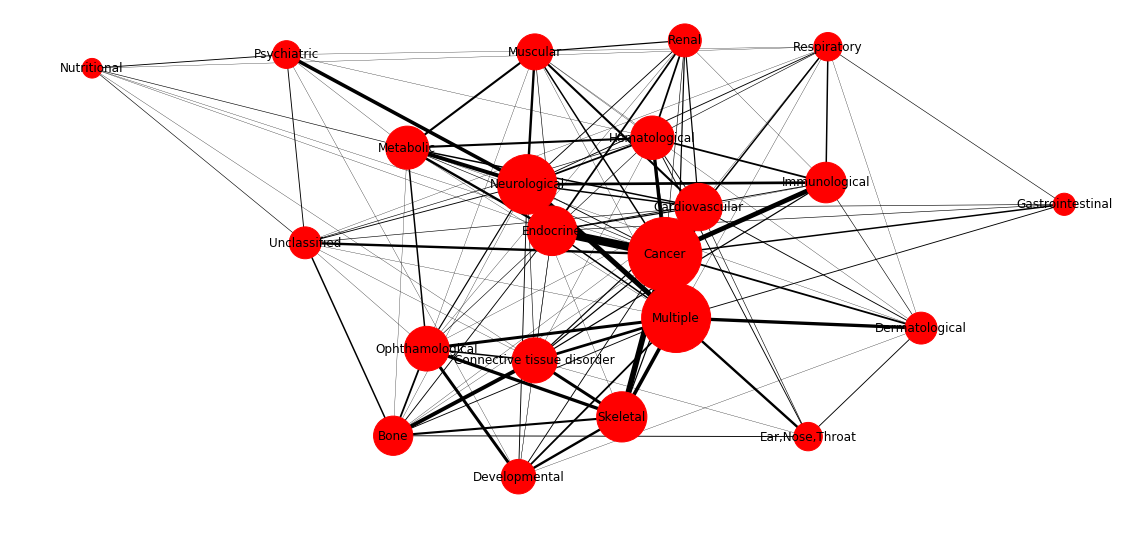

In [14]:
plt.rcParams['figure.figsize']=[15,7] #Just to make the figures quite bigger
degrees = G.degree(weight="weight")
edges_weights = nx.get_edge_attributes(G,'weight')
nx.draw(G,node_size= [degrees[e]*35 for e in G.nodes()],width=[edges_weights[e]*0.3 for e in G.edges()],with_labels=True)

### Node color is the % of self links

/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


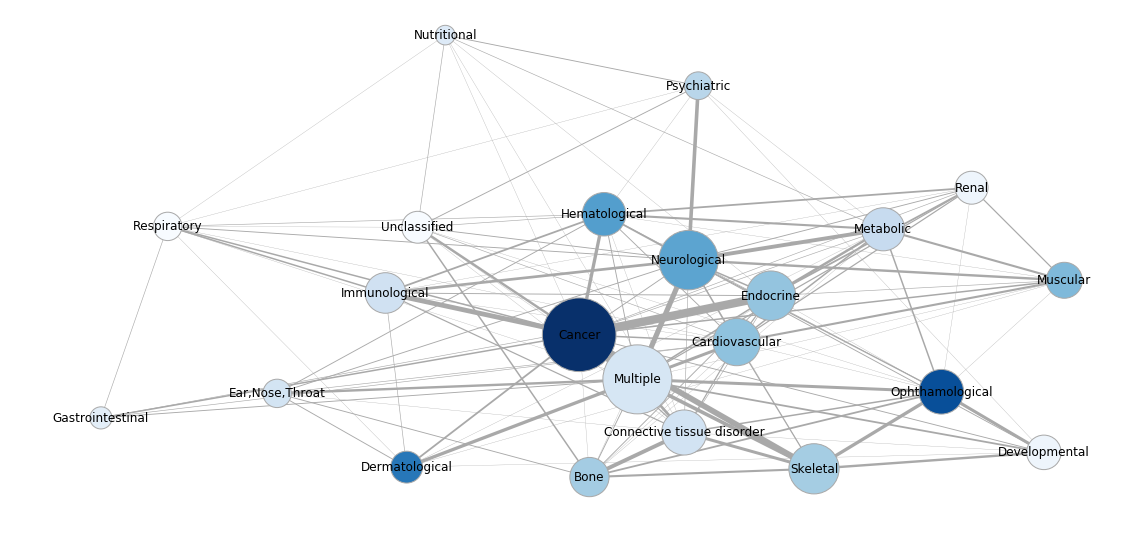

In [23]:
degrees = G.degree(weight="weight")
edges_weights = nx.get_edge_attributes(G,'weight')
nx.draw(G, linewidths=1,node_color=self_links, cmap=plt.cm.Blues,node_size= [degrees[e]*35 for e in G.nodes()],width=[edges_weights[e]*0.3 for e in G.edges()],with_labels=True)
ax = plt.gca() # to get the current axis
ax.collections[0].set_edgecolor("darkgrey") 
ax.collections[1].set_edgecolor("darkgrey") 

In [17]:
import pprint as pp
self_link_prop = {}
for i in range(len(self_links)):
    self_link_prop[labels[i]] = self_links[i]
pp.pprint(self_link_prop)

{'Bone': 0.22807017543859648,
 'Cancer': 0.6386946386946387,
 'Cardiovascular': 0.26436781609195403,
 'Connective tissue disorder': 0.12121212121212122,
 'Dermatological': 0.46296296296296297,
 'Developmental': 0.02857142857142857,
 'Ear,Nose,Throat': 0.11538461538461539,
 'Endocrine': 0.2553191489361702,
 'Gastrointestinal': 0.06666666666666667,
 'Hematological': 0.36470588235294116,
 'Immunological': 0.12962962962962962,
 'Metabolic': 0.15873015873015872,
 'Multiple': 0.10526315789473684,
 'Muscular': 0.28846153846153844,
 'Neurological': 0.34838709677419355,
 'Nutritional': 0.08333333333333333,
 'Ophthamological': 0.5615384615384615,
 'Psychiatric': 0.18518518518518517,
 'Renal': 0.03125,
 'Respiratory': 0.0,
 'Skeletal': 0.22580645161290322,
 'Unclassified': 0.0}


### <a id="eda_bi_cycle">Cycles</a>

In [18]:
Cb_G = nx.cycle_basis(G)
len(Cb_G)

104

In [19]:
e = sum([1 if len(cycle) % 2 == 0 else 0 for cycle in Cb_G])
print("{} cycles have an even length.".format(e))
print("{} cycles have an odd length.".format(len(Cb_G)-e))

7 cycles have an even length.
97 cycles have an odd length.


### <a id="eda_bi_cluster">Clustering</a>

In [20]:
C_G = nx.transitivity(G)
C_G

0.6148046607265251

In [21]:
C_avg_G = nx.average_clustering(G)
C_avg_G

0.6590825098846489

In [22]:
nx.diameter(G)

2

### <a id="eda_bi_deg">Degree distribution</a>

In [23]:
from collections import Counter

def deg_df(g):
    deg = dict(nx.degree(g))
    deg_df = pd.DataFrame(list(Counter(deg.values()).items()),columns=["k","count"]).sort_values(by="k")
    deg_df["p(k)"] = deg_df["count"] / deg_df["count"].sum()
    deg_df["log_k"] = np.log10(deg_df["k"])
    deg_df["log_p(k)"] = np.log10(deg_df["p(k)"])
    deg_df.sort_values(by="k",ascending=False,inplace=True)
    deg_df["cum_p(k)"] = deg_df["p(k)"].cumsum()
    deg_df["log_cum_p(k)"] = np.log10(deg_df["cum_p(k)"])
    display(deg_df.head(3))
    return deg_df

def log_bin(df,b=2): #not fully functional yet
    df = df.sort_values(by="k").reset_index(drop=True)
    n_bins = int(np.log(df.shape[0])/np.log(b))
    bin_df = pd.DataFrame(index=[i for i in range(n_bins+1)],columns=df.columns)
    for i in range(n_bins):
        bin_df.iloc[i] = df.iloc[int(b**i-1):int(b**(i+1)-1)].sum()
    bin_df.iloc[i+1] = df.iloc[int(b**(i+1)-1):].sum()
    bin_df = bin_df.astype("float64")
    return bin_df

In [24]:
G_deg = deg_df(G)

,k,count,p(k),log_k,log_p(k),cum_p(k),log_cum_p(k)
1,18,4,0.181818,1.255273,-0.740363,0.181818,-0.740363
2,14,2,0.090909,1.146128,-1.041393,0.272727,-0.564271
5,13,1,0.045455,1.113943,-1.342423,0.318182,-0.497325


/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


<Figure size 640x480 with 0 Axes>

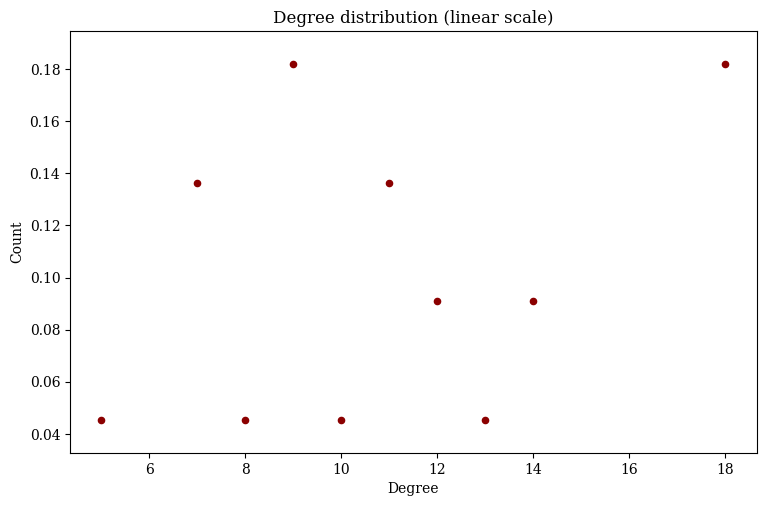

In [25]:
fig,ax = newfig(1.5)
G_deg.plot.scatter(x="k",y="p(k)",ax=ax,title="Degree distribution (linear scale)",c="darkred")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


<Figure size 640x480 with 0 Axes>

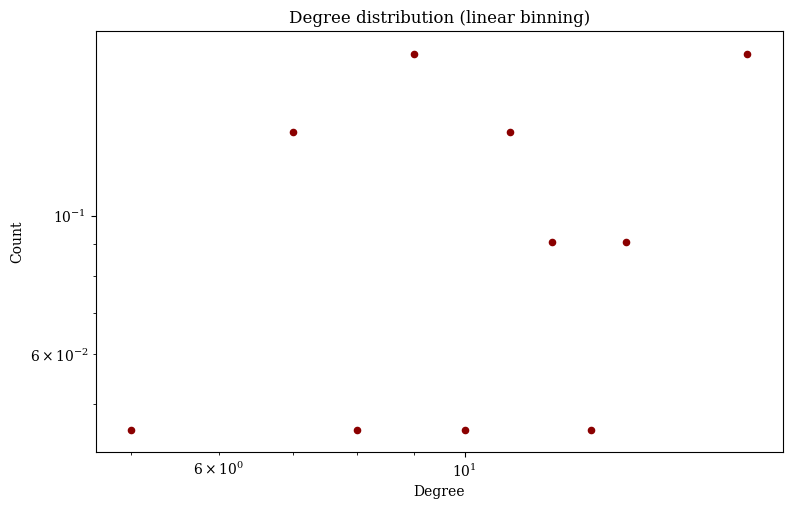

In [26]:
fig,ax = newfig(1.5)
G_deg.plot.scatter(x="k",y="p(k)",loglog=True,ax=ax,title="Degree distribution (linear binning)",c="darkred")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


<Figure size 640x480 with 0 Axes>

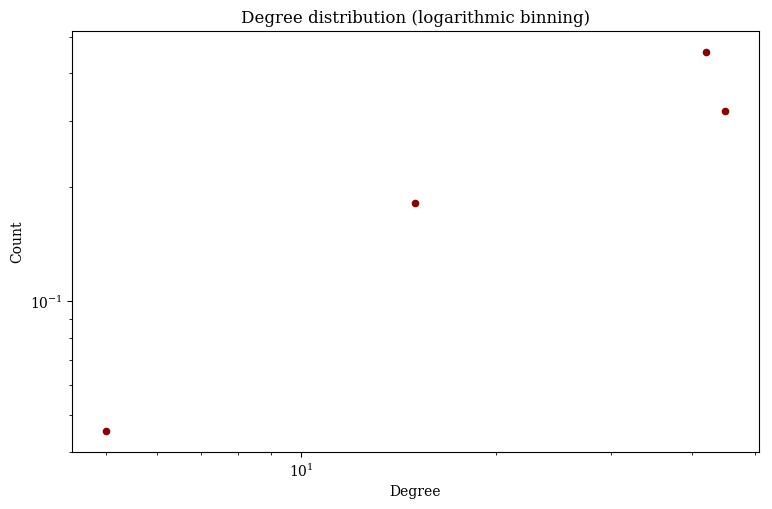

In [27]:
log_df = log_bin(G_deg,b=2)

fig,ax = newfig(1.5)
log_df.plot.scatter(x="k",y="p(k)",loglog=True,ax=ax,title="Degree distribution (logarithmic binning)",c="darkred")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


<Figure size 640x480 with 0 Axes>

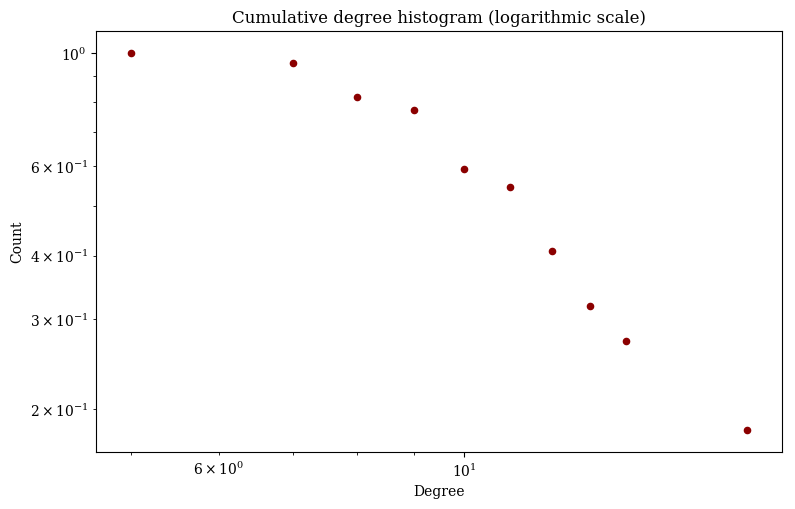

In [28]:
fig,ax = newfig(1.5)
G_deg.plot.scatter(x="k",y="cum_p(k)",loglog=True,ax=ax,title="Cumulative degree histogram (logarithmic scale)",c="darkred")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

In [29]:
new_df = pd.merge(df,dis,left_on="Source",right_on="Id")

In [30]:
display(new_df.info(),new_df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1550 entries, 0 to 1549
Data columns (total 7 columns):
Source      1550 non-null int64
Target      1550 non-null int64
Edge_id     1550 non-null int64
Id          1550 non-null int64
Label       1550 non-null object
Class       1550 non-null object
Subclass    1550 non-null object
dtypes: int64(4), object(3)
memory usage: 96.9+ KB


None

,Source,Target,Edge_id,Id,Label,Class,Subclass
0,1285,3211,0,1285,3-methylglutaconicaciduria,disease,Metabolic
1,468,2914,1,468,Aarskog-Scott syndrome,disease,Multiple
2,416,3825,2,416,ABCD syndrome,disease,Multiple
3,126,2566,3,126,Abetalipoproteinemia,disease,Metabolic
4,126,1329,4,126,Abetalipoproteinemia,disease,Metabolic
